In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

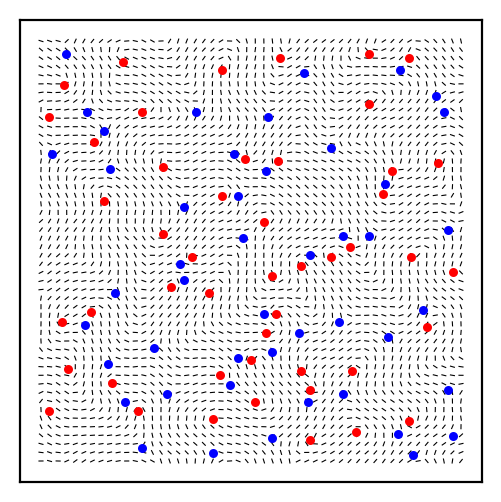

In [2]:
from skimage.transform import downscale_local_mean
from scipy.interpolate import interp2d
from defects import defect_coordinates
from winding import winding
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_axis(ax, sincos, skip=4):
    twoT = np.arctan2(sincos[0], sincos[1])
    theta = twoT / 2
    theta[theta < 0] += np.pi
    theta[theta > np.pi] -= np.pi
    
    defs = defect_coordinates(theta)
    wind = winding(theta)
    charge = -wind[defs[:, 1], defs[:, 0]]
    defs = defs / sincos.shape[-1]
    
    x, y = np.meshgrid(
        np.linspace(0, 1, sincos.shape[-1]//skip),
        np.linspace(0, 1, sincos.shape[-1]//skip))
    slc = np.s_[::skip, ::skip]
    ax.quiver(x, y, np.cos(theta)[slc], np.sin(theta)[slc], pivot='middle',
              headwidth=0, headlength=0, headaxislength=0)
    ax.scatter(defs[charge > 0, 0], defs[charge > 0, 1], color='red', s=5)
    ax.scatter(defs[charge < 0, 0], defs[charge < 0, 1], color='blue', s=5)
    ax.set(xticks=[], yticks=[])
    ax.set_aspect('equal')

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
import h5py
with h5py.File('../../data/activity_assay/z0.02.hdf5', 'r') as h5f:
    director = h5f['director'][0]
    sincos = np.stack([
        2*director[0]*director[1],
        director[0]**2-director[1]**2
    ])

    plot_axis(ax, sincos)

# Original frame predictor

*Most* of these models can still predict short term defect events like nucleations and annihilations.

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.155 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.127
Change from IC: Target: 0.289, ResAE: 0.230
Change from IC: Target: 0.418, ResAE: 0.322
Change from IC: Target: 0.534, ResAE: 0.405


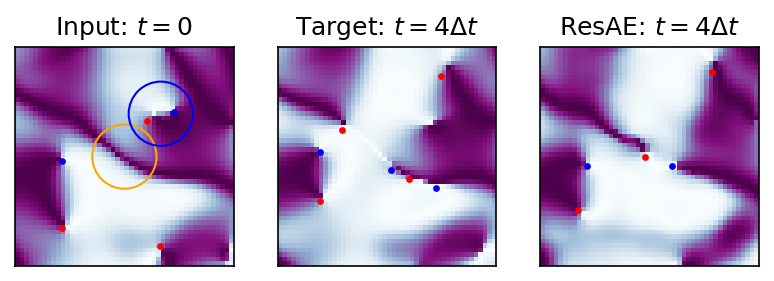

In [3]:
import torch
import torch.nn.functional as F

import sharpen

from dataset import *
from torchvision.transforms import Compose

def plot_axis(ax, sincos, skip=4):
    twoT = np.arctan2(sincos[0], sincos[1])
    theta = twoT / 2
    theta[theta < 0] += np.pi
    theta[theta > np.pi] -= np.pi
    
    defs = defect_coordinates(theta)
    wind = winding(theta)
    charge = -wind[defs[:, 1], defs[:, 0]]
    defs = defs / sincos.shape[-1]

    x, y = np.meshgrid(
        np.linspace(0,1, sincos.shape[-1]),
        np.linspace(0,1, sincos.shape[-1]),
    )
    ax.pcolormesh(x, y, sincos[0], cmap='BuPu')
    
    ax.scatter(defs[charge > 0, 0], defs[charge > 0, 1], color='red', s=5)
    ax.scatter(defs[charge < 0, 0], defs[charge < 0, 1], color='blue', s=5)
    ax.set(xticks=[], yticks=[])
    ax.set_aspect('equal')

def predict_model(model, inputs, tmax=1):
    pred = sharpen.loop_frame_prediction(model, inputs, device, input_size=48,
                                         n=tmax, stitch_ratio=0.05, border=3, nsharp=1)
    return pred

from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v1'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation over 4 frames (40 sim steps)
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}') # Compare to baseline of no dynamics
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.18 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.139
Change from IC: Target: 0.289, ResAE: 0.234
Change from IC: Target: 0.418, ResAE: 0.318
Change from IC: Target: 0.534, ResAE: 0.395


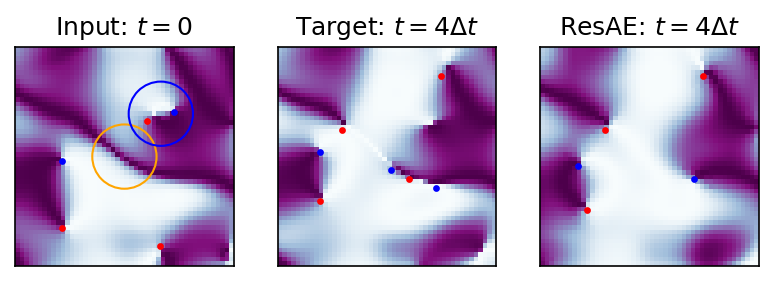

In [4]:
from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v2'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.154 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.145
Change from IC: Target: 0.289, ResAE: 0.267
Change from IC: Target: 0.418, ResAE: 0.378
Change from IC: Target: 0.534, ResAE: 0.480


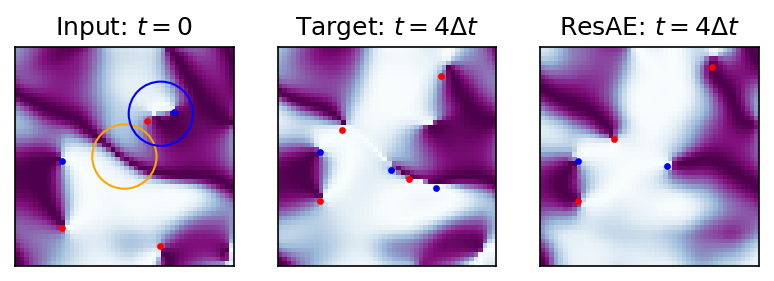

In [5]:
from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v3'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.153 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.139
Change from IC: Target: 0.289, ResAE: 0.249
Change from IC: Target: 0.418, ResAE: 0.345
Change from IC: Target: 0.534, ResAE: 0.431


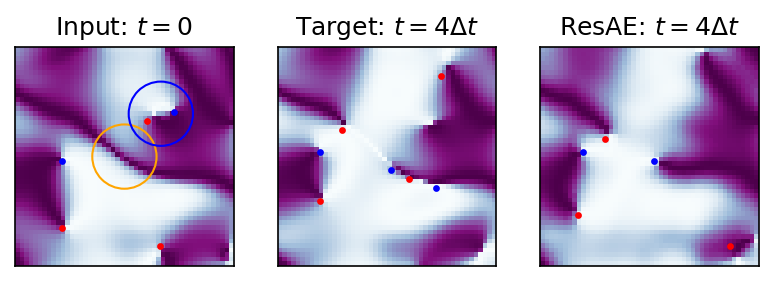

In [7]:
from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v4'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.147 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.139
Change from IC: Target: 0.289, ResAE: 0.248
Change from IC: Target: 0.418, ResAE: 0.345
Change from IC: Target: 0.534, ResAE: 0.430


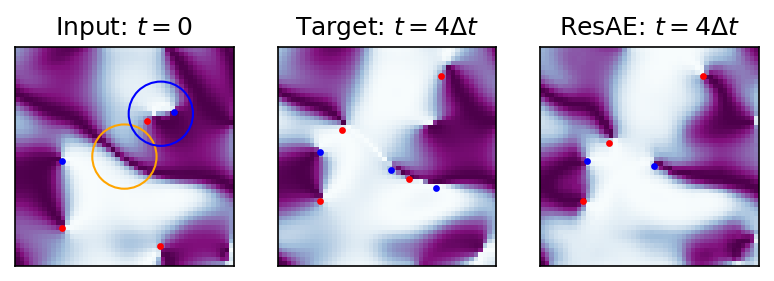

In [8]:
from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v5'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.21 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.084
Change from IC: Target: 0.289, ResAE: 0.132
Change from IC: Target: 0.418, ResAE: 0.173
Change from IC: Target: 0.534, ResAE: 0.210


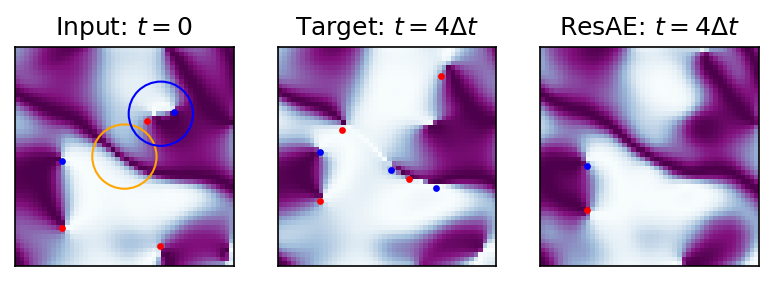

In [9]:
# This one fails to train and exhibits purely static dynamics

from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v6'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.187 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.126
Change from IC: Target: 0.289, ResAE: 0.211
Change from IC: Target: 0.418, ResAE: 0.285
Change from IC: Target: 0.534, ResAE: 0.350


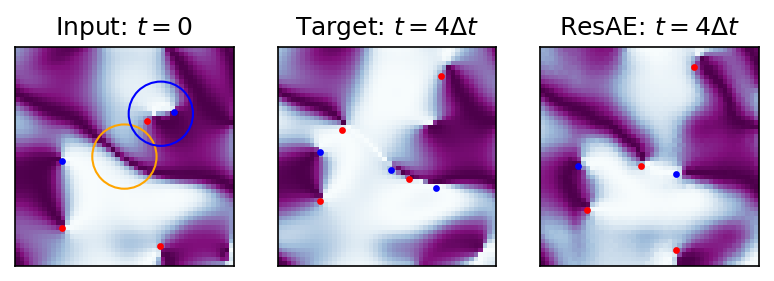

In [10]:

from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v7'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ResAE loss: 0.168 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.129
Change from IC: Target: 0.289, ResAE: 0.227
Change from IC: Target: 0.418, ResAE: 0.312
Change from IC: Target: 0.534, ResAE: 0.388


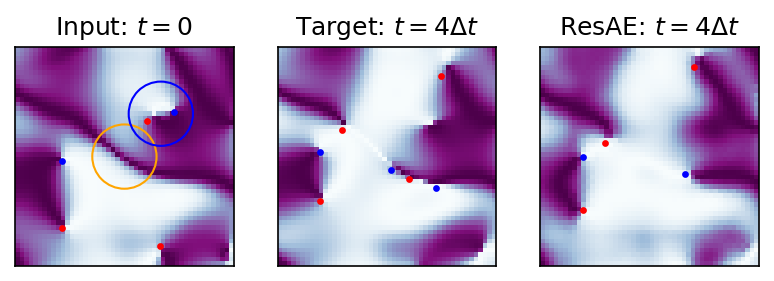

In [11]:

from res_ae import ResidualFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ResidualFramePredictor_v8'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ResidualFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = predict_model(model, inputs.clone(), tmax=target.shape[0])
    pred = torch.FloatTensor(np.stack([
        np.sin(2*pred),
        np.cos(2*pred),
    ], axis=1)).to(device)

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ResAE loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

# ConvNext Frame Predictor

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ConvNext loss: 0.0704 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.147
Change from IC: Target: 0.289, ResAE: 0.276
Change from IC: Target: 0.418, ResAE: 0.392
Change from IC: Target: 0.534, ResAE: 0.495


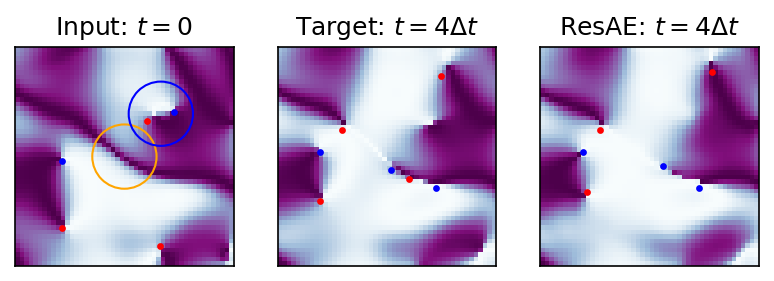

In [12]:
from res_ae_convnext import ConvNextFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ConvNextFramePredictor_v1'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ConvNextFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = model(inputs.clone()[None], tmax=target.shape[0])[0]

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ConvNext loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()

fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ConvNext loss: 0.0621 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.148
Change from IC: Target: 0.289, ResAE: 0.282
Change from IC: Target: 0.418, ResAE: 0.405
Change from IC: Target: 0.534, ResAE: 0.515


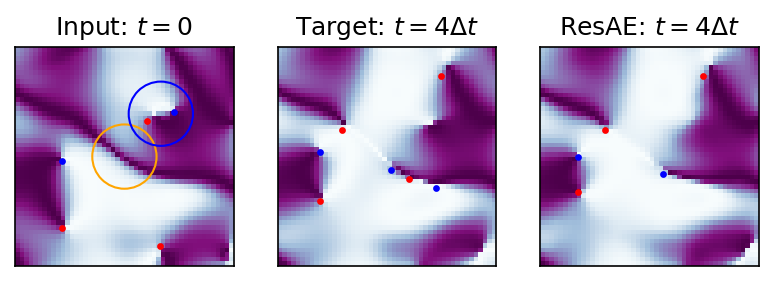

In [13]:
from res_ae_convnext import ConvNextFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ConvNextFramePredictor_v2'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ConvNextFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = model(inputs.clone()[None], tmax=target.shape[0])[0]

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ConvNext loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)

INFO:dataset:Found director field at ../../data/activity_assay/z0.03.hdf5 with 589 sequences


ConvNext loss: 0.0677 Static loss: 0.222
Change from IC: Target: 0.150, ResAE: 0.148
Change from IC: Target: 0.289, ResAE: 0.277
Change from IC: Target: 0.418, ResAE: 0.392
Change from IC: Target: 0.534, ResAE: 0.491


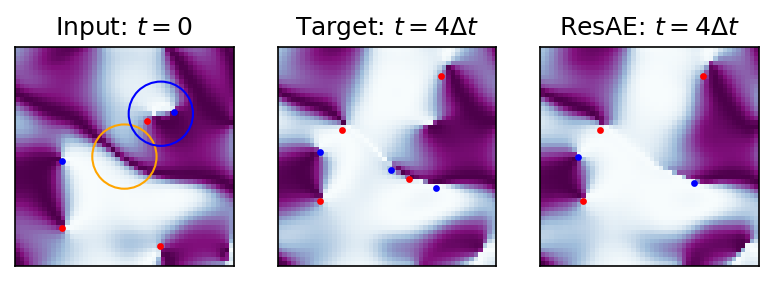

In [14]:
from res_ae_convnext import ConvNextFramePredictor

device = torch.device('cuda:0')
model_dir = '../models/ConvNextFramePredictor_v3'
info = torch.load(f'{model_dir}/model_weight.ckpt', map_location='cpu', weights_only=True)
model = ConvNextFramePredictor().to(device)
model.load_state_dict(info['state_dict'])
model.eval()

transform = Compose([
    SinCos(),
	ToTensor()
])

ds = NematicsSequenceDataset(f'../../data/activity_assay/z0.03.hdf5', frames_per_seq=7+4, transform=transform)

# Center frame defect nucleation and an off-center defect annihilation
sample = ds[99].to(device)
crop = np.s_[..., 40:88, 40:88]

with torch.no_grad():
    inputs = sample[:7]
    target = sample[7:]
    
    pred = model(inputs.clone()[None], tmax=target.shape[0])[0]

    loss = F.l1_loss(pred, target).item()
    static = inputs[-1, None].expand_as(target)
    loss_static = F.l1_loss(static, target).item()

    print(f'ConvNext loss: {loss:.3g} Static loss: {loss_static:.3g}')
    
    inputs = inputs.cpu().numpy()
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
fig, ax = plt.subplots(1, 3, dpi=150)

plot_axis(ax[0], inputs[-1][crop])
plot_axis(ax[1], target[-1][crop])
plot_axis(ax[2], pred[-1][crop])

for i in range(target.shape[0]):
    dt  = np.linalg.norm(target[i]  - inputs[-1], axis=0).mean()
    dp1 = np.linalg.norm(pred[i]   - inputs[-1], axis=0).mean()

    print(f'Change from IC: Target: {dt:.3f}, ResAE: {dp1:.3f}')

ax[0].set_title(r'Input: $t = 0$')
ax[1].set_title(r'Target: $t = 4 \Delta t$')
ax[2].set_title(r'ResAE: $t = 4 \Delta t$')

# Show where the nucleation and annihilation occur in the input
circle_nuc = plt.Circle((0.5, 0.5), 0.15, edgecolor='orange', fill=None)
circle_ann = plt.Circle((0.67, 0.7), 0.15, edgecolor='blue', fill=None)

ax[0].add_patch(circle_nuc)
ax[0].add_patch(circle_ann)